<a href="https://colab.research.google.com/github/AdhamelGazar/Face_Mask_Detection-Deep_Learning/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DOWNLOADING TH DATASET USING KAGGLE 


In [1]:
 !pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhamamr3","key":"44168fbbd818667be54252e916c566b1"}'}

In [4]:
 !mkdir ~/.kaggle

In [6]:
# copy the json file to the folder .kaggle in the root directory
!cp kaggle.json ~/.kaggle/

In [7]:
# change folder permissions to be able to read and write
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!pwd

/content


In [9]:
!mkdir dataset

In [10]:
%cd /content/dataset

/content/dataset


In [11]:
!pwd

/content/dataset


In [12]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 98% 323M/330M [00:02<00:00, 140MB/s]
100% 330M/330M [00:02<00:00, 145MB/s]


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzipping the dataset

In [14]:
!unzip /content/dataset/face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

# Exploring the dataset

In [15]:
%cd /content/dataset/Face Mask Dataset/Train

/content/dataset/Face Mask Dataset/Train


In [16]:
import os

In [17]:
print(f"We have a total number of {len(os.listdir('./'))} classes")

We have a total number of 2 classes


In [18]:
for folder in os.listdir('./'):
  images = [x for x in os.listdir(f'./{folder}') if (x.endswith('.jpg') or x.endswith('.jpeg') or x.endswith('.png'))]
  print(f'{folder} : {len(images)} images')



WithoutMask : 5000 images
WithMask : 5000 images


# **Reading and showing the image**

In [19]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [20]:
img = cv.imread('/content/dataset/Face Mask Dataset/Train/WithMask/1004.png')

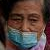

In [21]:
cv2_imshow(img)

# Data Generator

In [22]:
import tensorflow.keras as keras
import numpy as np
from sklearn.model_selection import train_test_split

In [23]:
CLASSES_labels = {}
for index, folder in enumerate(os.listdir('./')):
  if folder.startswith('.'):
    continue
  CLASSES_labels[folder] = index

In [24]:
CLASSES_labels

{'WithMask': 1, 'WithoutMask': 0}

In [25]:
images_paths = []
images_labels = []
for folder in os.listdir('./'):
  images = [folder + '/' + x for x in os.listdir(f'./{folder}') if (x.endswith('.jpg') or x.endswith('.jpeg') or x.endswith('.png'))]
  images_paths = images_paths + images
  label = CLASSES_labels[folder]
  images_labels = images_labels + [label] * len(images)

In [26]:
len(images_paths), len(images_labels)

(10000, 10000)

In [27]:
print(list(zip(images_paths[::1000], images_labels[::1000])))

[('WithoutMask/5681.png', 0), ('WithoutMask/4934.png', 0), ('WithoutMask/4481.png', 0), ('WithoutMask/910.png', 0), ('WithoutMask/134.png', 0), ('WithMask/Augmented_104_6044175.png', 1), ('WithMask/Augmented_316_7588018.png', 1), ('WithMask/Augmented_113_7629159.png', 1), ('WithMask/206.png', 1), ('WithMask/Augmented_567_8517007.png', 1)]


In [28]:
images_paths_train, images_paths_test, images_labels_train, images_labels_test = train_test_split(images_paths, images_labels, test_size=0.1, stratify=images_labels, random_state=42)
images_paths_train, images_paths_validation, images_labels_train, images_labels_validation = train_test_split(images_paths_train, images_labels_train, test_size=0.1, stratify=images_labels_train, random_state=42)

In [29]:
len(images_paths_train), len(images_paths_validation), len(images_paths_test)

(8100, 900, 1000)

In [30]:
import numpy as np


In [31]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=16, dim=(64,128), n_channels=1,
              n_classes=2, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of steps per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    list_labels_temp = [self.labels[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp, list_labels_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp, list_labels_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img = cv.imread(ID,cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, self.dim[::-1])          
        X[i,] =  np.expand_dims(img_resized, axis=2)

        # Store class
        y[i] = list_labels_temp[i]

    return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [32]:
train_generator = DataGenerator(list_IDs= images_paths_train, labels= images_labels_train)
validation_generator = DataGenerator(list_IDs= images_paths_validation, labels= images_labels_validation)
test_generator = DataGenerator(list_IDs= images_paths_test, labels= images_labels_test)

(16, 64, 128, 1)
(16, 2)


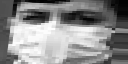

[0. 1.]


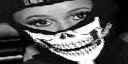

[0. 1.]


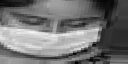

[0. 1.]


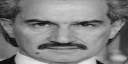

[1. 0.]


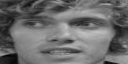

[1. 0.]


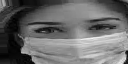

[0. 1.]


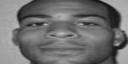

[1. 0.]


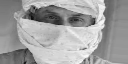

[0. 1.]


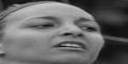

[1. 0.]


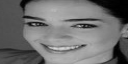

[1. 0.]


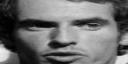

[1. 0.]


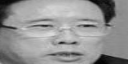

[1. 0.]


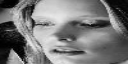

[1. 0.]


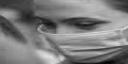

[0. 1.]


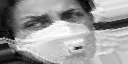

[0. 1.]


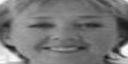

[1. 0.]


In [33]:
for images, labels in train_generator:
  print(images.shape)
  print(labels.shape)
  for index in range(len(labels)):
    cv2_imshow(images[index])
    print(labels[index])
  break

# Model Dev

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [35]:
model = tf.keras.Sequential()
model.add(Input(shape=(64,128, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 126, 128)      1280      
_________________________________________________________________
dropout (Dropout)            (None, 62, 126, 128)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 126, 128)      512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 124, 128)      147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 62, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 62, 128)       5

In [36]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
acc_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Best acc/best_accuracy_face_mask.h5', monitor="val_accuracy")


In [38]:
model.fit(x = train_generator,
          validation_data = validation_generator,
          epochs=20,
          callbacks=[acc_checkpoint])

Epoch 1/20
506/506 [==============================] - 84s 102ms/step - loss: 0.2020 - accuracy: 0.9314 - val_loss: 0.1120 - val_accuracy: 0.9542
Epoch 2/20
506/506 [==============================] - 52s 102ms/step - loss: 0.1126 - accuracy: 0.9612 - val_loss: 0.0730 - val_accuracy: 0.9799
Epoch 3/20
506/506 [==============================] - 52s 102ms/step - loss: 0.0871 - accuracy: 0.9707 - val_loss: 0.0846 - val_accuracy: 0.9621
Epoch 4/20
506/506 [==============================] - 52s 102ms/step - loss: 0.0654 - accuracy: 0.9784 - val_loss: 0.0513 - val_accuracy: 0.9877
Epoch 5/20
506/506 [==============================] - 52s 102ms/step - loss: 0.0761 - accuracy: 0.9736 - val_loss: 0.4404 - val_accuracy: 0.8438
Epoch 6/20
506/506 [==============================] - 51s 102ms/step - loss: 0.0795 - accuracy: 0.9725 - val_loss: 0.1212 - val_accuracy: 0.9665
Epoch 7/20
506/506 [==============================] - 52s 102ms/step - loss: 0.0570 - accuracy: 0.9806 - val_loss: 0.0427 - val_ac

# **Evaluating model**

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model = load_model('/content/drive/MyDrive/Best acc/best_accuracy_face_mask.h5')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 126, 128)      1280      
_________________________________________________________________
dropout (Dropout)            (None, 62, 126, 128)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 126, 128)      512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 124, 128)      147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 62, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 62, 128)       5

In [43]:
test_generator = DataGenerator(list_IDs= images_paths_test, labels= images_labels_test, batch_size=120, shuffle=False)

In [44]:
y_pred = []
y_true = []
for images, labels in test_generator:
  labels_pred = model.predict(images)
  labels_pred = np.argmax(labels_pred, axis=1)
  labels = np.argmax(labels, axis=1)
  y_pred += list(labels_pred)
  y_true += list(labels)

  


  

In [45]:
len(y_pred), len(y_true)

(960, 960)

In [46]:
from sklearn.metrics import classification_report

In [47]:
target_names = list(CLASSES_labels.keys())

In [48]:
CLASSES_labels.keys()

dict_keys(['WithoutMask', 'WithMask'])

In [49]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 WithoutMask       0.98      0.99      0.98       483
    WithMask       0.99      0.97      0.98       477

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

